In [121]:
# IMPORTS
##########
##########

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

from astropy.visualization import hist
from astropy.stats import histogram
from astropy.io import fits
import astropy.units as u

import ccdproc
from ccdproc import subtract_overscan
from ccdproc import trim_image
from ccdproc import CCDData

In [27]:
#CLD this cell is for all of the constants added throughout the notebook

#CLD local path to data, must change in order to run on personal computer
path = '../../../../imaging/reduced_data/'


Based on visual inspection, the overscan region on the left hand side goes from 1 to 54 and on the left hand side seems to go from 2101 to 2200. I will be adding this to the header of every image we are working with (or, if working in python to fits indices, 0 to 52 and 2100 to 2199). From the log book: 

-bais: a093-a111.fits

-darks: d01-d15.fits

-flats: a001-a062 (1-21 Halpha, 22-28 are U, 29-42 B, 43-49 V, 50-55 R, 56-62 I)

665.8330812766335


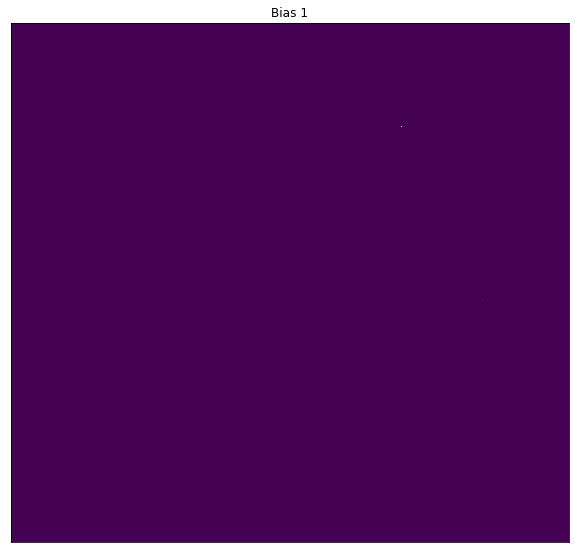

In [114]:
#CLD using python to plot the lines and columns of one of the biases
#CLD I will be using a093.fits for this excersice
#CLD opeing bias frame and plot to show it
b1_data = fits.getdata(path+"a093.fits")
print(np.mean(b1_data))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(b1_data, vmin=666, vmax=7536)
plt.xticks([])
plt.yticks([])
plt.title('Bias 1')
plt.grid(False)
plt.show()

In [7]:
#CLD the chip is 2048 X 2200 so center should be like 1024 and 1100
#CLD because of this will be looking at a region around like 1020-1028 and 1096 and 1104
b1_center = b1_data[1020:1028, 1096:1104]

#CLD RMS will be the standard deviation
rms = np.std(b1_center)

#CLD the mean is the mean
mean = np.mean(b1_center)

print('The RMS is: '+str(rms))
print('The mean is: '+str(mean))

The RMS is: 9.316261299973021
The mean is: 671.359375


## Problem 5

This is an attempt to quantify whether or not the biases are a good example of the overscan region throughout the night. To do this, first looking at all of the biases taken and the mean level of all of the pixels in the bias. Then look at the mean level of the overscan region, which is noted in one of the first cells, in a different set of images that were taken through out the night, ie with different time signatures. 

For this I will be looking at every other science image up until the baises. I will also be looking at the lefthand side of the overscan, or the bigger portion. 

In [21]:
#CLD begin by opening all of the baises data into a master data frame
baises_data = []
for i in range(111-93):
    if i<7:
        data = fits.getdata(path+"a0"+str(int(i+93))+".fits")
        baises_data.append(data)
    if i>=7:
        data = fits.getdata(path+"a"+str(int(i+93))+".fits")
        baises_data.append(data)
        
baises_data = np.array(baises_data)

#CLD making an array of the mean level of each bias
bais_mean = []
for i in range(len(baises_data)):
    mean = np.mean(baises_data[i,:])
    bais_mean.append(mean)
    
bais_mean = np.array(bais_mean)
print(bais_mean)
print(np.std(bais_mean))

[665.83308128 665.50395131 665.5575142  665.67133811 665.65969438
 665.63690829 665.59073242 665.55084783 665.57650435 665.5441748
 665.5616748  665.55110019 665.54791104 665.58815718 665.53799472
 665.60195113 665.59595925 665.62843905]
0.0717694806159146


Overall, it seems like the bais level is pretty consistent throughout the night. This is seen in the low standard deviation from each mean.

Next, I will do a similar process to look at the overscan region in the science images.

In [20]:
#CLD begin by opening all of the flats overscan data into a master data frame
sci_data = []
for i in range(92-70):
    data = fits.getdata(path+"a0"+str(int(i+70))+".fits")
    sci_data.append(data[:,2102:2200])
        
sci_data = np.array(sci_data)

#CLD making an array of the mean level of each flat overscan region
sci_mean = []
for i in range(len(sci_data)):
    mean = np.mean(sci_data[i,:])
    sci_mean.append(mean)
    
sci_mean = np.array(sci_mean)
print(sci_mean)
print(np.std(sci_mean))

[660.90770488 660.04110531 661.03261519 660.12828842 661.01810627
 661.05385045 662.05293367 663.05667052 663.56174267 664.54508131
 665.76598872 661.64457609 663.12129803 663.78644173 662.89166633
 662.45422114 663.01397581 661.75139509 662.93529775 661.95527742
 663.17296118 664.70322465]
1.4565186370825964


There is definitley much more internal deviation between the overscan region of these flats.

To compare the standard variation in the baises to the variation in the overscan regions of the flats, I am going to subtract the mean of the mean for the biases from all of the means of the flats. If they are close to 0, then the bias level is similar to the overscan level in the flats. 

In [22]:
#CLD using the mean of the means as repersentative variation
#CLD feel comfortable doing this as there is very little deviation between the means
bais_mean_level = np.mean(bais_mean)

#CLD subtracting this repersentative mean to the means of the flats
differences = sci_mean - bais_mean_level

print(differences)

[-4.68884703 -5.5554466  -4.56393671 -5.46826348 -4.57844564 -4.54270146
 -3.54361823 -2.53988139 -2.03480924 -1.05147059  0.16943681 -3.95197582
 -2.47525388 -1.81011018 -2.70488557 -3.14233077 -2.5825761  -3.84515682
 -2.66125416 -3.64127448 -2.42359073 -0.89332726]


To me, this indicates that the mean level of the baises, and therefore the master bais, would not be a good description of the kind of variation we see in the overscan region through out the night. This is especially true early on. It seems it would be best to model the overscan region in each frame and then subtract this out from the images.

## Problem 6

For this problem, I am first going to investigate the best overscan modeling on a science image in this order: ’chebychev’, ’legandre’, and ’hermite’, and ’polynomial' order 1 through 8. I will look at science image 85 in the V filter. I will be using an overscan region of [ :,2102-2200]. Some of the first pixels of overscan are left out as there is not an instanteous drop off at the edge of the overscan, but more gradual. By omitting some of the frist values, you get a better fit.

In [61]:
#CLD importing the astropy.models package for ccdproc purposes
from astropy.modeling import models

#CLD loading in the science data
science_data = fits.getdata(path+"a085.fits")

#CLD changing fits array data to CCDdata
ccd_science = CCDData(science_data, unit=u.adu)

#CLD instantiating polynomial models
p1 = models.Polynomial1D(degree=1)
p2 = models.Polynomial1D(degree=2)
p3 = models.Polynomial1D(degree=3)
p4 = models.Polynomial1D(degree=4)
p5 = models.Polynomial1D(degree=5)
p6 = models.Polynomial1D(degree=6)
p7 = models.Polynomial1D(degree=7)
p8 = models.Polynomial1D(degree=8)

#CLD instantiating the other model types for orders 1 through 8
c1 = models.Chebyshev1D(degree=1)
c2 = models.Chebyshev1D(degree=2)
c3 = models.Chebyshev1D(degree=3)
c4 = models.Chebyshev1D(degree=4)
c5 = models.Chebyshev1D(degree=5)
c6 = models.Chebyshev1D(degree=6)
c7 = models.Chebyshev1D(degree=7)
c8 = models.Chebyshev1D(degree=8)

le1 = models.Legendre1D(degree=1)
le2 = models.Legendre1D(degree=2)
le3 = models.Legendre1D(degree=3)
le4 = models.Legendre1D(degree=4)
le5 = models.Legendre1D(degree=5)
le6 = models.Legendre1D(degree=6)
le7 = models.Legendre1D(degree=7)
le8 = models.Legendre1D(degree=8)

h1 = models.Hermite1D(degree=1)
h2 = models.Hermite1D(degree=2)
h3 = models.Hermite1D(degree=3)
h4 = models.Hermite1D(degree=4)
h5 = models.Hermite1D(degree=5)
h6 = models.Hermite1D(degree=6)
h7 = models.Hermite1D(degree=7)
h8 = models.Hermite1D(degree=8)

#CLD chebyshev model subtractions
sub_c1 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=c1)
sub_c2 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=c2)
sub_c3 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=c3)
sub_c4 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=c4)
sub_c5 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=c5)
sub_c6 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=c6)
sub_c7 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=c7)
sub_c8 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=c8)

#CLD legendre model subtractions
sub_le1 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=le1)
sub_le2 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=le2)
sub_le3 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=le3)
sub_le4 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=le4)
sub_le5 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=le5)
sub_le6 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=le6)
sub_le7 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=le7)
sub_le8 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=le8)

#CLD Hermite model subtractions
sub_h1 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=h1)
sub_h2 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=h2)
sub_h3 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=h3)
sub_h4 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=h4)
sub_h5 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=h5)
sub_h6 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=h6)
sub_h7 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=h7)
sub_h8 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=h8)

#CLD polynomial model subtractions
sub_p1 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=p1)
sub_p2 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=p2)
sub_p3 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=p3)
sub_p4 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=p4)
sub_p5 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=p5)
sub_p6 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=p6)
sub_p7 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=p7)
sub_p8 = ccdproc.subtract_overscan(ccd_science, overscan=ccd_science[:,2102:2200], model=p8)

 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


I will now be displaying this single science image with the different orders and models of subtraction. The first panel will be the Chebyshev models, the next will be Legendre, then Hermite, and lastly the Polynomial fits, all in sequential order (ie, the first graph is degree=1, the next to the right is degree=2, etc etc)

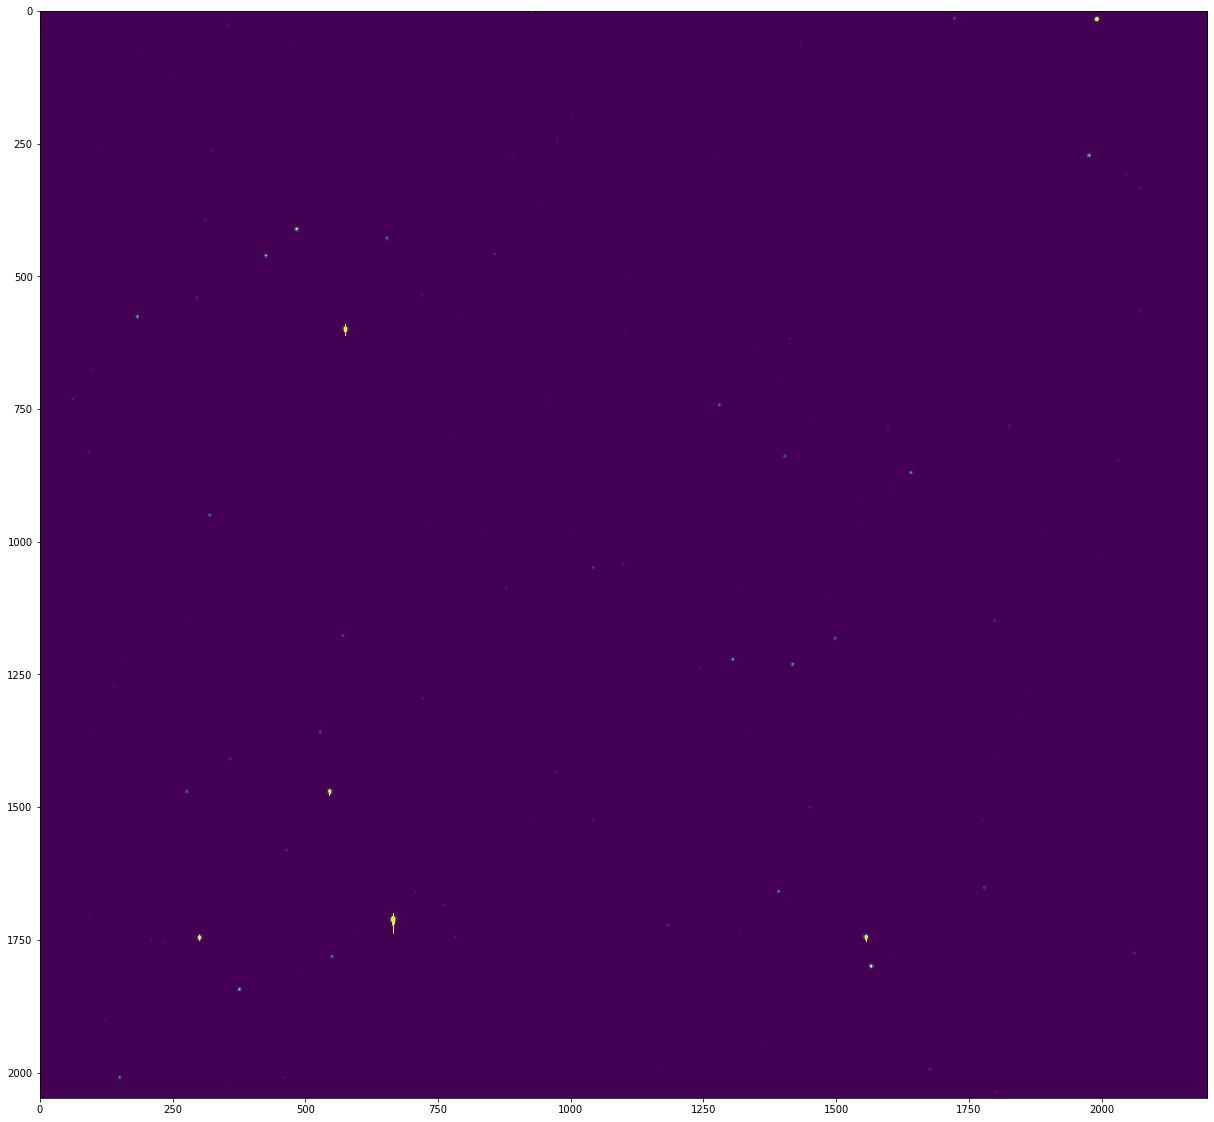

In [172]:
#CLD this cell plots the Chebyshev subtractions of this science image
cheby = [np.array(sub_c1), np.array(sub_c2), np.array(sub_c3), np.array(sub_c4), np.array(sub_c5)
         , np.array(sub_c6), np.array(sub_c7), np.array(sub_c8)]

fig, ax = plt.subplots(1,1,figsize=(30,20))
ax.imshow(cheby[0], vmin=np.mean(cheby[0]))
#ax[1].imshow(cheby[1], vmin=np.mean(cheby[1]))
#ax[2].imshow(cheby[2], vmin=np.mean(cheby[2]))
#ax[3].imshow(cheby[3], vmin=np.mean(cheby[3]))
#ax[0].imshow(cheby[4], vmin=np.mean(cheby[4]))
#ax[1,1].imshow(cheby[5], vmin=np.mean(cheby[5]))
#ax[1,2].imshow(cheby[6], vmin=np.mean(cheby[6]))
#ax[1,3].imshow(cheby[7], vmin=np.mean(cheby[7]))
#fig.set_title('Chebyshev Overscan Subtraction')
plt.show(fig)

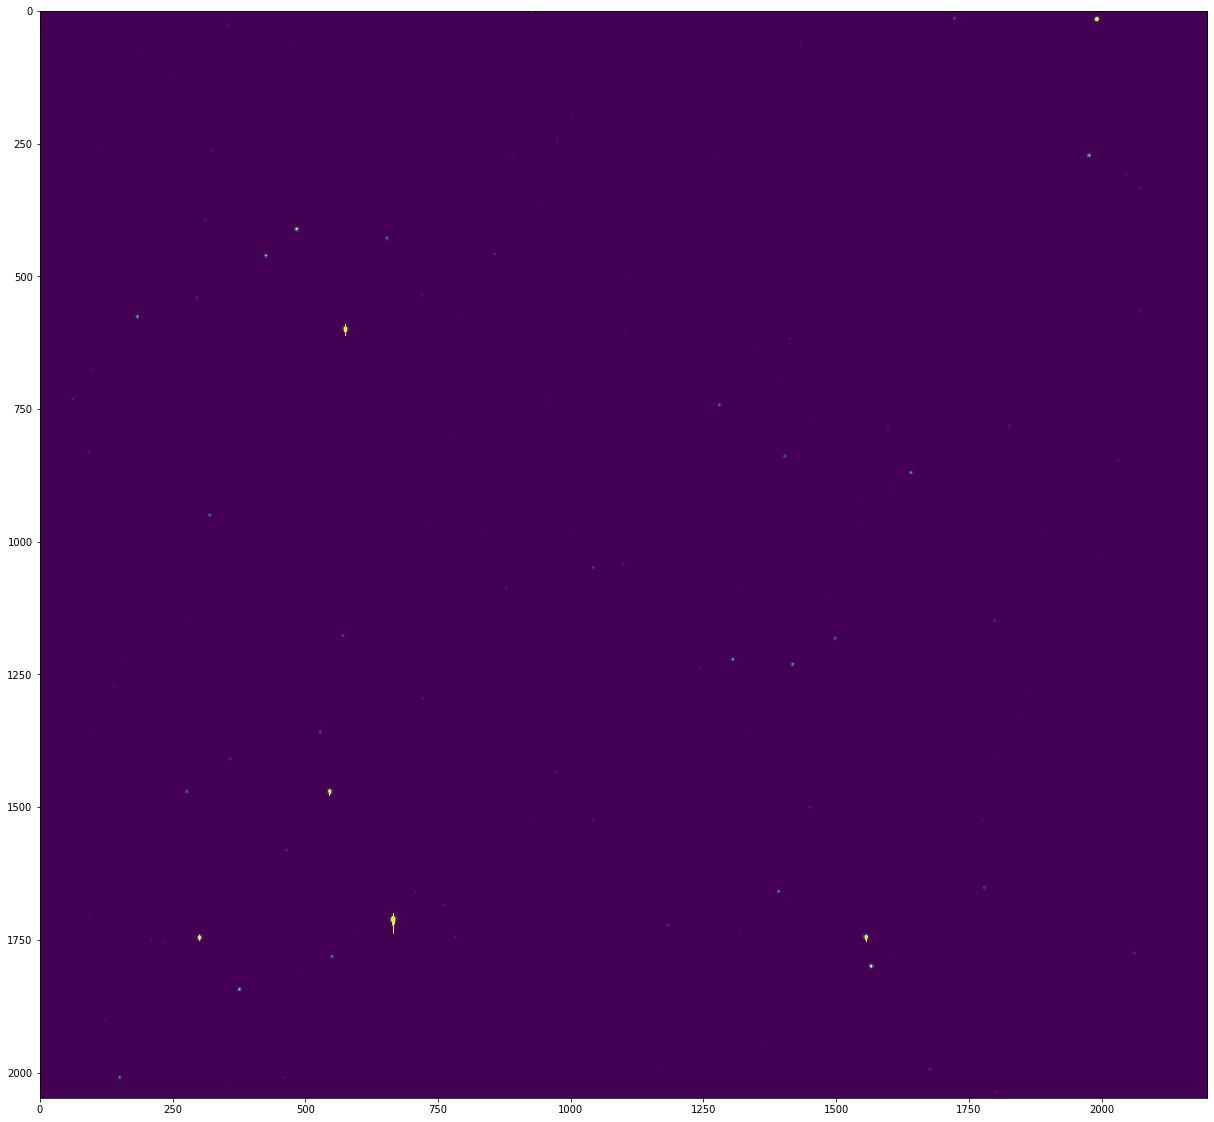

In [173]:
#CLD this cell plots the Legendre subtractions of this science image
le = [np.array(sub_le1), np.array(sub_le2), np.array(sub_le3), np.array(sub_le4), np.array(sub_le5)
         , np.array(sub_le6), np.array(sub_le7), np.array(sub_le8)]

fig, ax = plt.subplots(1,1, figsize=(30,20))
ax.imshow(le[0], vmin=np.mean(le[0]))
#ax[1].imshow(le[1], vmin=np.mean(le[1]))
#ax[2].imshow(le[2], vmin=np.mean(le[2]))
#ax[3].imshow(le[3], vmin=np.mean(le[3]))
#ax[1,0].imshow(le[4], vmin=np.mean(le[4]))
#ax[1,1].imshow(le[5], vmin=np.mean(le[5]))
#ax[1,2].imshow(le[6], vmin=np.mean(le[6]))
#ax[1,3].imshow(le[7], vmin=np.mean(le[7]))
#fig.set_title('Chebyshev Overscan Subtraction')
plt.show(fig)

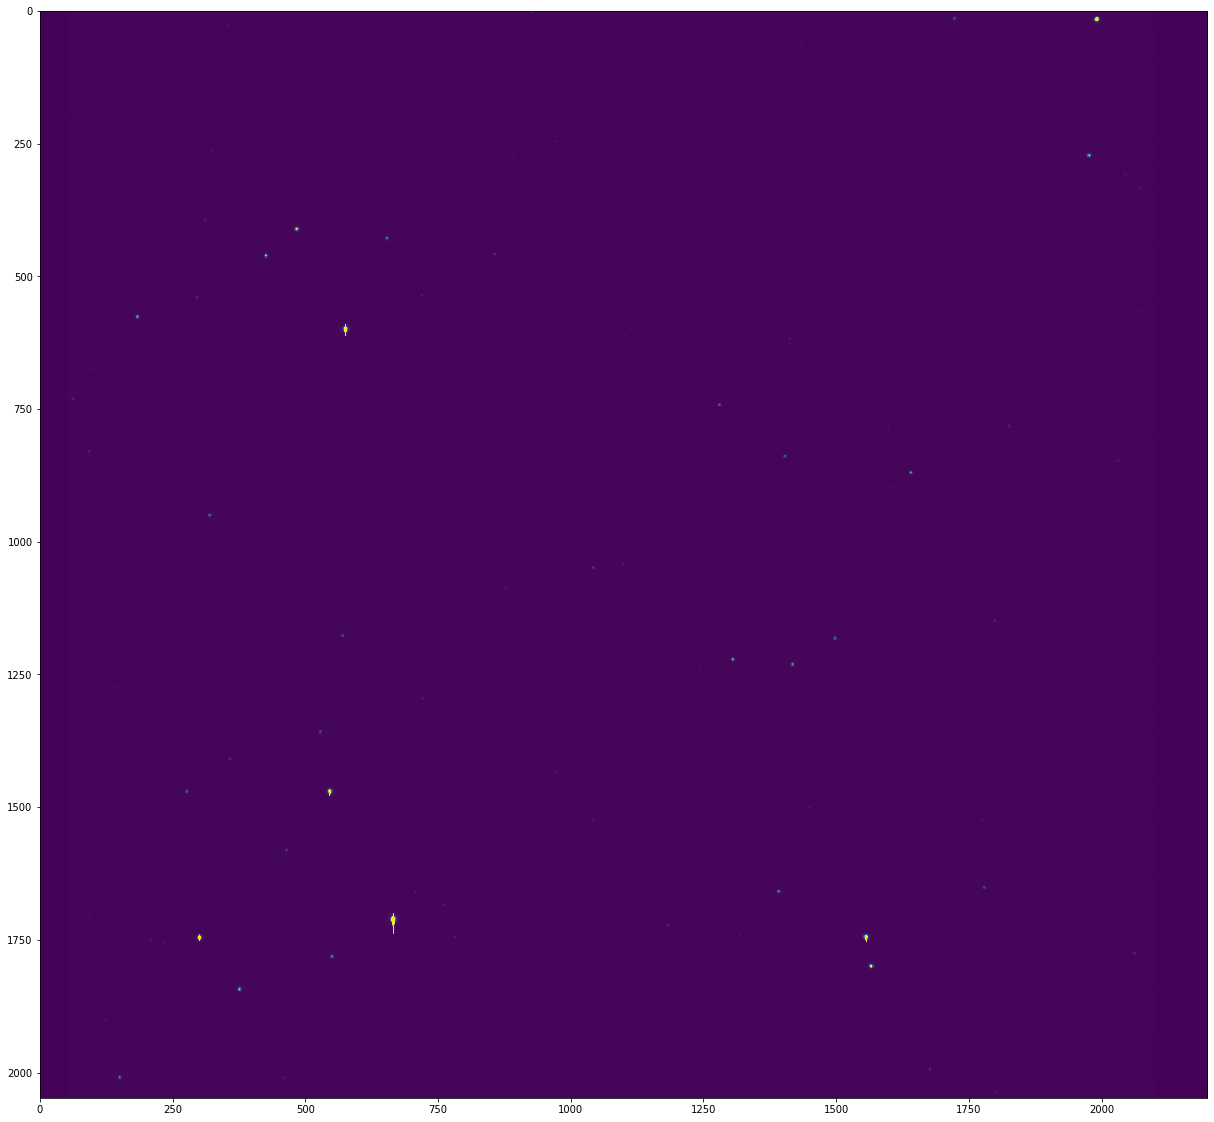

In [174]:
#CLD this cell plots the Hermit subtractions of this science image
h = [np.array(sub_h1), np.array(sub_h2), np.array(sub_h3), np.array(sub_h4), np.array(sub_h5)
         , np.array(sub_h6), np.array(sub_h7), np.array(sub_h8)]

fig, ax = plt.subplots(1,1,figsize=(30,20))
ax.imshow(h[0], vmin=np.min(h[0]))
#ax[0,1].imshow(h[1], vmin=np.mean(h[1]))
#ax[0,2].imshow(h[2], vmin=np.mean(h[2]))
#ax[0,3].imshow(h[3], vmin=np.mean(h[3]))
#ax[1,0].imshow(h[4], vmin=np.mean(h[4]))
#ax[1,1].imshow(h[5], vmin=np.mean(h[5]))
#ax[1,2].imshow(h[6], vmin=np.mean(h[6]))
#ax[1,3].imshow(h[7], vmin=np.mean(h[7]))
#fig.set_title('Chebyshev Overscan Subtraction')
plt.show(fig)

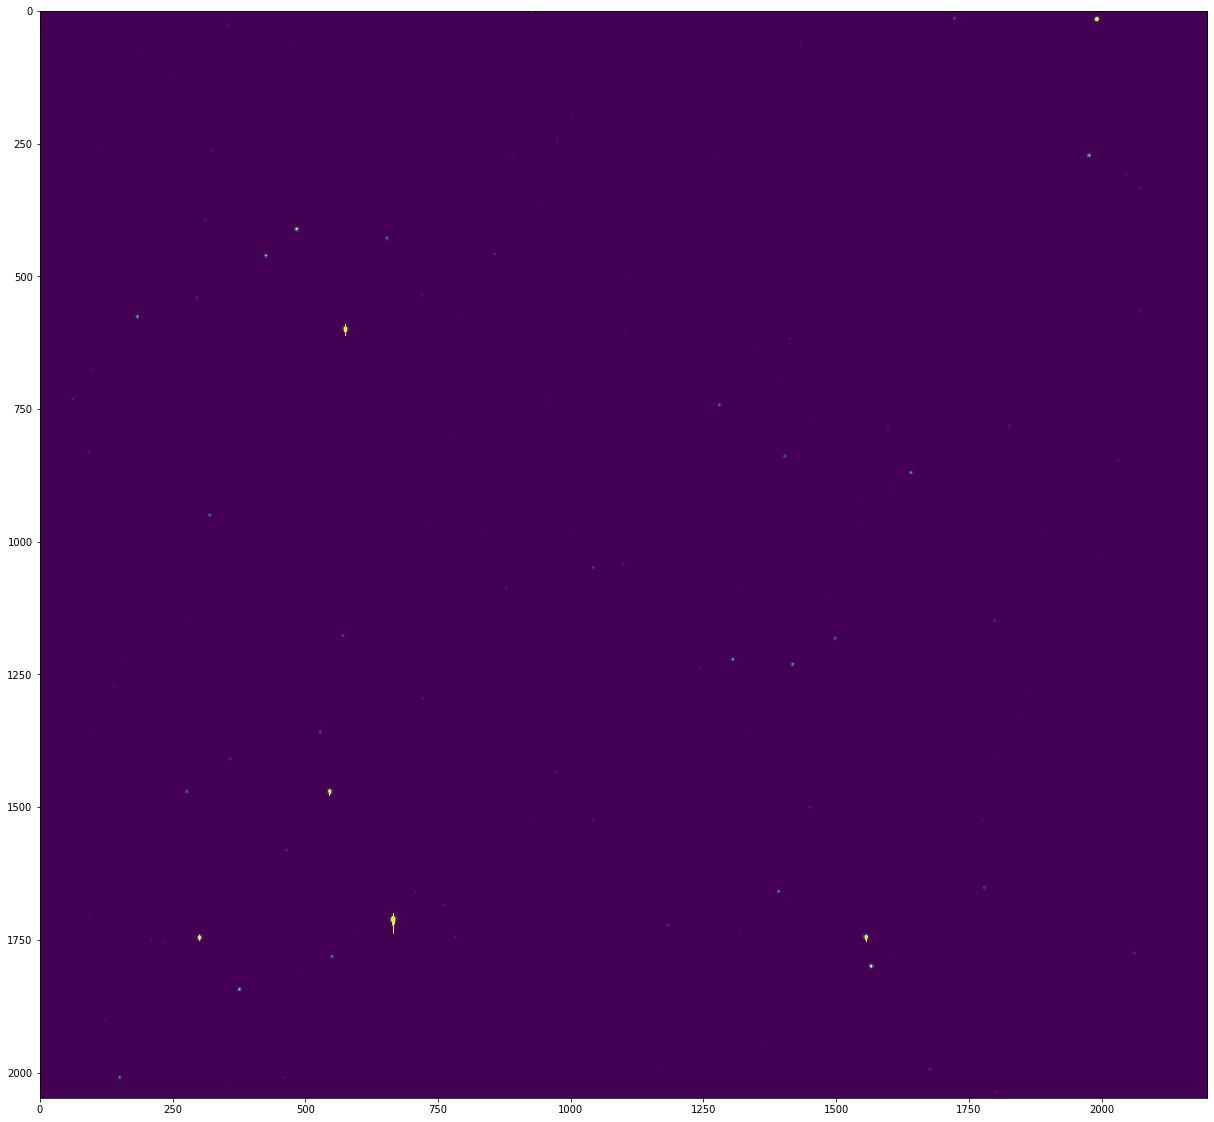

In [176]:
#CLD this cell plots the Polynomial subtractions of this science image
p = [np.array(sub_p1), np.array(sub_p2), np.array(sub_p3), np.array(sub_p4), np.array(sub_p5)
         , np.array(sub_p6), np.array(sub_p7), np.array(sub_p8)]

fig, ax = plt.subplots(1,1,figsize=(30,20))
ax.imshow(p[0], vmin=np.mean(p[0]))
#ax[0,1].imshow(p[1], vmin=np.mean(p[1]))
#ax[0,2].imshow(p[2], vmin=np.mean(p[2]))
#ax[0,3].imshow(p[3], vmin=np.mean(p[3]))
#ax[1,0].imshow(p[4], vmin=np.mean(p[4]))
#ax[1,1].imshow(p[5], vmin=np.mean(p[5]))
#ax[1,2].imshow(p[6], vmin=np.mean(p[6]))
#ax[1,3].imshow(p[7], vmin=np.mean(p[7]))
#fig.set_title('Chebyshev Overscan Subtraction')
plt.show(fig)

In [ ]:
#CLD put an argument about the model I am going to use to do the fitting

To make an argument about max order I should fit too, I am going to do a self fit real quick of the overscan of a flat.

51548.47510342685


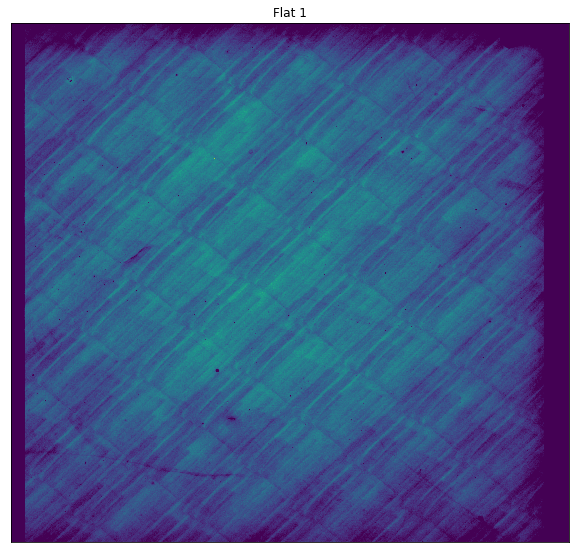

In [151]:
#CLD retriving flat data
f1_data = fits.getdata(path+"a022.fits")

#CLD plotting the flat
print(np.mean(f1_data))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(f1_data, vmin=51548.47510342685)
plt.xticks([])
plt.yticks([])
plt.title('Flat 1')
plt.grid(False)
plt.show()

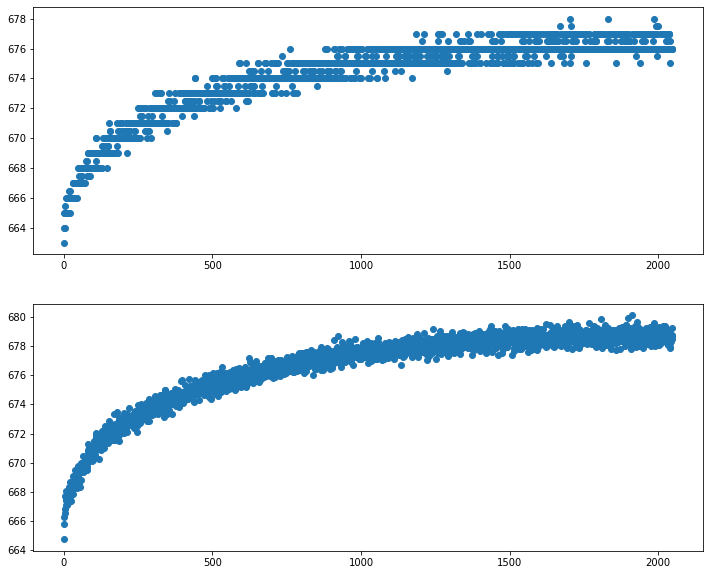

In [152]:
#CLD collapsing the data of the left overscan region to look at values vs pixels
f1_overscan = f1_data[:,2102:2200]
f1_overscan_collapse_median = np.median(f1_overscan, axis=1)
f1_overscan_collapse_average = np.mean(f1_overscan, axis=1)

#CLD plotting
pixels = np.linspace(0,2048,2048)
fig,ax = plt.subplots(2,1,figsize=(12,10))
ax[0].scatter(pixels, f1_overscan_collapse_median)
ax[1].scatter(pixels, f1_overscan_collapse_average);

In [153]:
#CLD the mean again looks better but IDK if this is what they should be looking like at all
#CLD I guess going on to fit the overscan region in the 
poly1 = np.polyfit(pixels, f1_overscan_collapse_average, 1)
poly2 = np.polyfit(pixels, f1_overscan_collapse_average, 2)
poly3 = np.polyfit(pixels, f1_overscan_collapse_average, 3)
poly4 = np.polyfit(pixels, f1_overscan_collapse_average, 4)

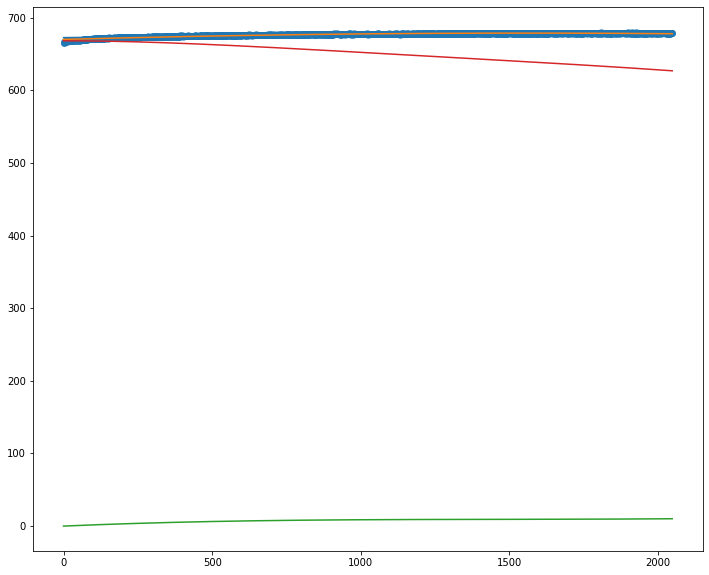

In [154]:
#CLD plotting all of the fits to see which one is best
fig,ax = plt.subplots(1,1,figsize=(12,10))
ax.scatter(pixels, f1_overscan_collapse_average, alpha=0.5);
ax.plot(pixels, poly1[0]*pixels**1 + poly1[1])
ax.plot(pixels, poly2[0]*pixels**2 + poly2[1]*pixels**1 + poly2[2])
ax.plot(pixels, poly3[0]*pixels**3 + poly3[1]*pixels**2 + poly3[2]*pixels + poly3[0])
ax.plot(pixels, poly4[0]*pixels**4 + poly4[1]*pixels**3 + poly4[2]*pixels**2 + poly4[1]*pixels + poly4[4])
#ax.set_ylim(680,720);

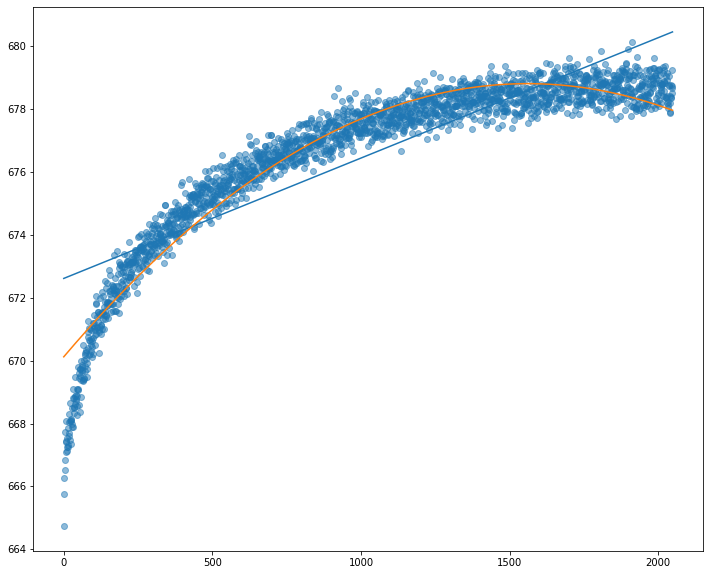

In [155]:
#CLD plotting all of the fits to see which one is best
fig,ax = plt.subplots(1,1,figsize=(12,10))
ax.scatter(pixels, f1_overscan_collapse_average, alpha=0.5);
ax.plot(pixels, poly1[0]*pixels**1 + poly1[1])
ax.plot(pixels, poly2[0]*pixels**2 + poly2[1]*pixels**1 + poly2[2])
#ax.plot(pixels, poly3[0]*pixels**3 + poly3[1]*pixels**2 + poly3[2]*pixels + poly3[0])
#ax.plot(pixels, poly4[0]*pixels**4 + poly4[1]*pixels**3 + poly4[2]*pixels**2 + poly4[1]*pixels + poly4[4])
#ax.set_ylim(680,720);

To me the above shows that you really don't need more than a second order fit in order to describe the overscan region suffiencently.

Now, I am going to iteratively subtract and remove the overscan for each image in this folder and save it as a"number"ot.fits ** Do I need to subtract the bais from the darks abd baises as well?? **

In [ ]:
#CLD making look to subtract and trim all images, minus darks and gains, in the imaging folder and to save them with
#CLD the ot addition to indicate this process having had happened
for i in range(0,241):
    if i<5:
        data = fits.getdata(path+"a00"+str(i+5)+".fits")
    if i>=5 and i<95:
        data = fits.getdata(path+"a0"+str(i+5)+".fits")
    else:
        data = fits.detdata(path+'a'+str(i+5)+'.fits')
    
    ccddata = CCDData(data, unit=u.adu)
    sub = ccdproc.subtract_overscan(ccddata, overscan=[:,2102:2200], model=p2)
    trim_sub = ccdproc.trim_image(fits_section=[:,53:2101])
    
    if i<5:
         fits.writeto(path+"a00"+str(i+5)+"ot.fits")
    if i>=5 and i<95:
        fits.writeto(path+"a0"+str(i+5)+"ot.fits")
    else:
        fits.writeto(path+'a'+str(i+5)+'ot.fits')

## Problem 7

This problem deals with creating a master bias image and the investiagtion of the validaity of this master bias.

The first step will be to investigate the data in all of these images.
Will be looking at the mean level in each image, along with the standard deviation, both in the individual images, and the images as a group.

If a frame is really off, do a visual inspection and decide wether or not to discount it. 

Using the final set of images (if there is enough) make a master bias images using mean combine.

In [116]:
#CLD doing image statistics on the bais data
#CLD data loaded in from question 5
#CLD already have array of means/levels for each image individually
#CLD along with the standard dev for these means
#CLD will now be finding the std dev of pixels in each frame and the global mean

global_mean = np.mean(bais_mean)
bais_std = []
for i in range(len(baises_data)):
    std = np.std(baises_data[i,:])
    bais_std.append(std)
    
print('The global mean for all baises: '+str(global_mean))
print("The std for each image's mean from this global mean: "+str(np.std(bais_mean)))
print("")
print("The mean of each image: "+str(bais_mean))
print("The std of each image from its own mean: "+str(bais_std))

The global mean for all baises: 665.5965519082425
The std for each image's mean from this global mean: 0.0717694806159146

The mean of each image: [665.83308128 665.50395131 665.5575142  665.67133811 665.65969438
 665.63690829 665.59073242 665.55084783 665.57650435 665.5441748
 665.5616748  665.55110019 665.54791104 665.58815718 665.53799472
 665.60195113 665.59595925 665.62843905]
The std of each image from its own mean: [9.532843321120467, 8.90440832302805, 8.92654707214331, 8.91783019372463, 9.15360021262778, 8.912341960236885, 8.909404771987573, 8.941481808818256, 8.907702048491156, 9.060101241508017, 9.204789382049897, 8.901463811227572, 8.899546963454311, 9.239660989475526, 8.98109366612888, 8.959462429710513, 8.932890176613084, 8.929579951952473]


To me, none of the baises look too, too different from one another, not to the point that I'm worried one should be investigated and discounted. Because of this, I feel comfortable making a master bais of all the bais frames included in this data set.

In [ ]:
#CLD making a master bais from all of these bais images
#CLD begin by making a list of bais data in the ccddata format
baises_ccd = []
for i in range(111-93):
    if i<7:
        data = fits.getdata(path+"a0"+str(int(i+93))+".fits")
        data = CCDData(data, unit=u.adu)
        baises_ccd.append(data)
    if i>=7:
        data = fits.getdata(path+"a"+str(int(i+93))+".fits")
        data = CCDData(data, unit=u.adu)
        baises_ccd.append(data)
        
#CLD using the combine funciton to make a master bais image
#CLD do sigma clipping??
master_bais = ccdproc.combine(baises_ccd , method='median', sigma_clipping=True)

#CLD changing data type to np array
master_bais = np.array(master_bais)

#CLD writing this out to a fits file in the image dir
fits.writeto(path+'master_bais.fits', master_bais, overwrite=True)

RMS: 3.2916369034533965


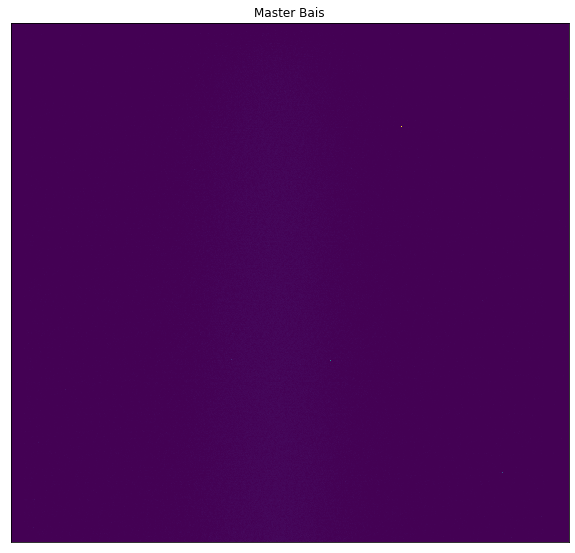

In [201]:
#CLD plotting the master bais to make sure there are no nonglobal trends that show up
master = fits.getdata(path+"master_bais.fits")

print('RMS: '+str(np.std(master)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(master, vmin=np.mean(master))
plt.xticks([])
plt.yticks([])
plt.title('Master Bais')
plt.grid(False)
plt.show()

Put argument here about wether or not I should subtract this master bais from all of the science frames or not and then do subtraction if it won't add too much noise

## Problem 8

The darks are denoted by the files d001-d015. WIRO has a gain equal to 2.5 electrons/ADU. 

Gain describes the number of electrons repersented by one ADU. These fits files, as they were read out from a CCD, store an array of ADU values that we can repersent in an "image". Therefore to find the ranges of dark current, which is dimensionally equal to electrons/pixel/second, we need the number of pixels a dark substends (by defintion 2048), the amount of time it was exposed (exposure time in the header) and the maximum/minimum ADU value mulitplied by 2.5

To quantitatively examine the ranges of dark currrent in these frames, I am going to begin by opening each frame individually and get the exposure time from the header and will store it in array of exposure times.

In [147]:
#CLD opening each dark frame iteratively and storing the exp time from header into an exp time array
exp_time = []
for i in range(15):
    if i<9:
        file = fits.open(path+"d00"+str(i+1)+".fits")
        header = file[0].header
        exp_time.append(header['EXPTIME'])
    if i>=9:
        file = fits.open(path+"d0"+str(i+1)+".fits")
        header = file[0].header
        exp_time.append(header['EXPTIME'])
    
exp_time = np.array(exp_time)

In [148]:
#CLD I will now be retriving the maximum and minimum values for each dark
#CLD the minimum value will be easy to retrive as there is no need to worry about cosmic rays
#CLD to check for cosmic rays, I will be taking the maximum value whose count is also one, as cosmic rays extend over
#CLD over multiple pixels
min_values = []
max_values = []

for i in range(15):
    if i<9:
        file = fits.getdata(path+"d00"+str(i+1)+".fits")
        min_values.append(np.min(file))
        
        unique, counts = np.unique(file, return_counts=True)
        unique = unique[counts==1] #CLD masking for where counts=1
        unique = unique[unique<10000] #CLD this is more reasoning I guess, no dark value should be that high
        max_values.append(np.max(unique))
        
    if i>=9:
        file = fits.getdata(path+"d0"+str(i+1)+".fits")
        min_values.append(np.min(file))
        
        unique, counts = np.unique(file, return_counts=True)
        unique = unique[counts==1] #CLD masking for where counts=1
        unique = unique[unique<10000]        
        max_values.append(np.max(unique))

min_max = np.array([min_values, max_values])

In [149]:
#CLD now solving for dark current based off of the found/given information
gain = 2.5
min_max_e = min_max*2.5

min_range = min_max_e[0,:]/2048/exp_time
max_range = min_max_e[1,:]/2048/exp_time

for i in range(15):
    print('The range of dark current for frame '+str(i+1)+' is: ['+str(min_range[i])+', '+str(max_range[i])+']')

The range of dark current for frame 1 is: [0.374755859375, 1.016845703125]
The range of dark current for frame 2 is: [0.3741455078125, 1.531982421875]
The range of dark current for frame 3 is: [0.3753662109375, 2.1124267578125]
The range of dark current for frame 4 is: [0.377197265625, 0.7537841796875]
The range of dark current for frame 5 is: [0.3729248046875, 0.93017578125]
The range of dark current for frame 6 is: [0.147705078125, 0.719970703125]
The range of dark current for frame 7 is: [0.150146484375, 0.439697265625]
The range of dark current for frame 8 is: [0.150390625, 1.11767578125]
The range of dark current for frame 9 is: [0.149658203125, 0.4375]
The range of dark current for frame 10 is: [0.150634765625, 0.3359375]
The range of dark current for frame 11 is: [0.002498372395833333, 0.02166748046875]
The range of dark current for frame 12 is: [0.0024658203125, 0.030989583333333334]
The range of dark current for frame 13 is: [0.0024698893229166668, 0.01907958984375]
The range 

## Problem 8

The purpose of this problem is to investigate the best methods to combine the darks into a master dark.

Must investigate at least these styles of combination:

-> straight average, no clipping

-> straight median, no clipping

-> average with 3sig clipping

-> median with 3sig clipping

I will investigate these in the above order.

In [180]:
#CLD making the CCDData objs to pass combine
d1 = CCDData(fits.getdata(path+"d001.fits"), unit=u.adu)        
d2 = CCDData(fits.getdata(path+"d002.fits"), unit=u.adu)
d3 = CCDData(fits.getdata(path+"d003.fits"), unit=u.adu)
d4 = CCDData(fits.getdata(path+"d004.fits"), unit=u.adu)
d5 = CCDData(fits.getdata(path+"d005.fits"), unit=u.adu)
d6 = CCDData(fits.getdata(path+"d006.fits"), unit=u.adu)
d7 = CCDData(fits.getdata(path+"d007.fits"), unit=u.adu)
d8 = CCDData(fits.getdata(path+"d008.fits"), unit=u.adu)
d9 = CCDData(fits.getdata(path+"d009.fits"), unit=u.adu)
d10 = CCDData(fits.getdata(path+"d010.fits"), unit=u.adu)
d11 = CCDData(fits.getdata(path+"d011.fits"), unit=u.adu)
d12 = CCDData(fits.getdata(path+"d012.fits"), unit=u.adu)
d13 = CCDData(fits.getdata(path+"d013.fits"), unit=u.adu)
d14 = CCDData(fits.getdata(path+"d014.fits"), unit=u.adu)
d15 = CCDData(fits.getdata(path+"d015.fits"), unit=u.adu)

#CLD making darks list
darks = [d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15]

#CLD doing the straight avg no clipping combine
straight_avg = ccdproc.combine(darks, method='average')

#CLD straight median
straight_med = ccdproc.combine(darks, method='median')

#CLD avg, 3sig
avg_3sig = ccdproc.combine(darks, method='average', sigma_clip=True) #CLD the default for sigma clip is to use mean 
#CLD func for modeling and std for sig with the low and high being 3

#CLD median 3sig
med_3sig = ccdproc.combine(darks, method='median', sigma_clip=True)

In [181]:
#CLD I am not going to display all of the above combinations
#CLD first going to turn them back into np arrays so I can do data analysis on them
straight_avg = np.array(straight_avg)
straight_med = np.array(straight_med)
avg_3sig = np.array(avg_3sig)
med_3sig = np.array(med_3sig)

RMS: 3.076591342639415


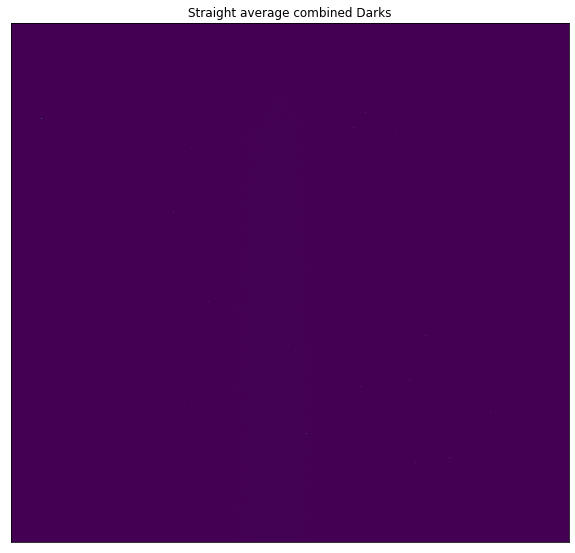

In [187]:
#CLD displaying the straight average

print('RMS: '+str(np.std(straight_avg)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(straight_avg, vmin=np.mean(straight_avg))
plt.xticks([])
plt.yticks([])
plt.title('Straight average combined Darks')
plt.grid(False)
plt.show()

RMS: 2.918116967637125


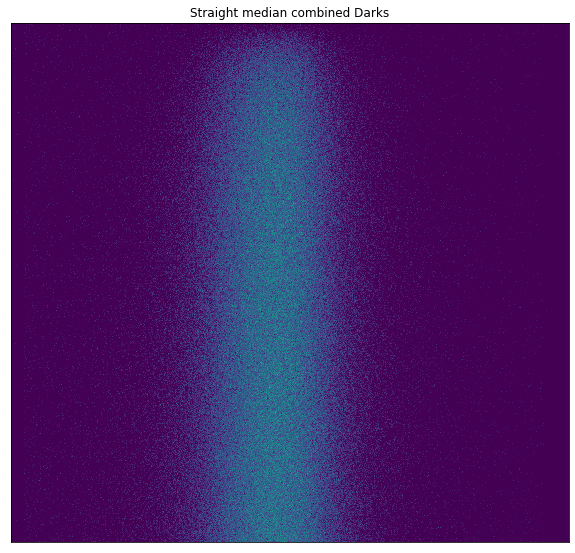

In [188]:
#CLD displaying the straight median

print('RMS: '+str(np.std(straight_med)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(straight_med, vmin=np.mean(straight_med))
plt.xticks([])
plt.yticks([])
plt.title('Straight median combined Darks')
plt.grid(False)
plt.show()

RMS: 2.8313169722072056


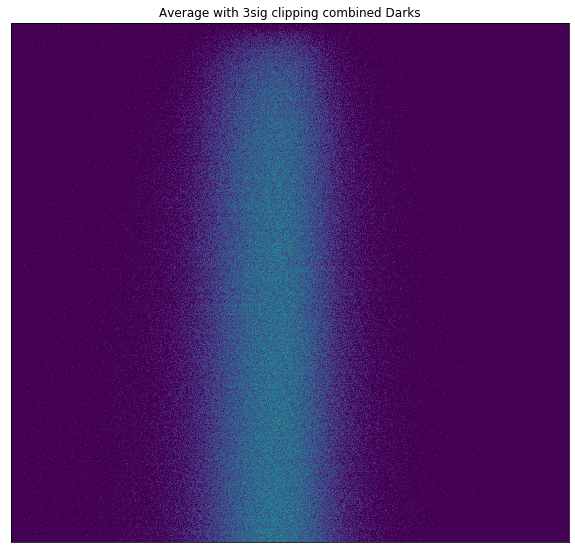

In [189]:
#CLD displaying the average with 3sig clipping

print('RMS: '+str(np.std(avg_3sig)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(avg_3sig, vmin=np.mean(avg_3sig))
plt.xticks([])
plt.yticks([])
plt.title('Average with 3sig clipping combined Darks')
plt.grid(False)
plt.show()

RMS: 2.9180825137797073


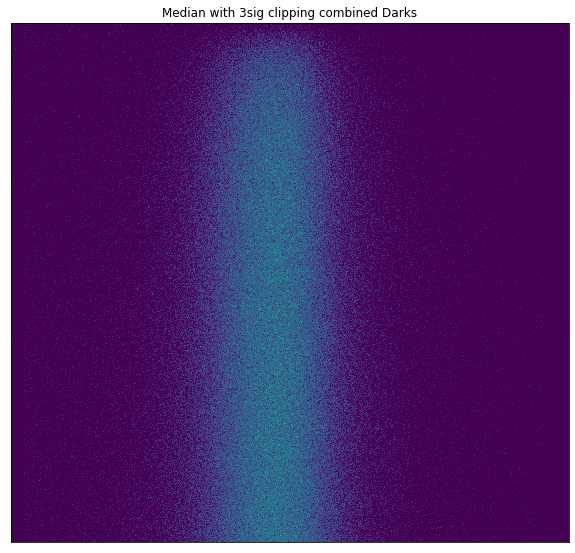

In [190]:
#CLD displaying the median with 3sig clipping

print('RMS: '+str(np.std(med_3sig)))
fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(med_3sig, vmin=np.mean(med_3sig))
plt.xticks([])
plt.yticks([])
plt.title('Median with 3sig clipping combined Darks')
plt.grid(False)
plt.show()

Ok, so it seems like one I need to subtract out the overscan/baises for the darks, and two that the average combine was maybe the worst/best? It does have the highest RMS value, but it does get rid of the pattern in the middle.